In [1]:
import os
import json
import tempfile

import wandb
from omegaconf import OmegaConf
import equinox as eqx
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from foundational_ssm.models import SSMFoundationalDecoder, SSMDownstreamDecoder, discretize_zoh

%load_ext autoreload
%autoreload 2

In [2]:
def load_model_from_checkpoint(artifact_full_name, model_class=SSMDownstreamDecoder, model_cfg_attr='downstream_model_cfg'):
    """
    Load the SSMFoundationalDecoder model from a checkpoint artifact.
    """
    api = wandb.Api()
    artifact = api.artifact(artifact_full_name, type="checkpoint")
    run = artifact.logged_by()
    run_cfg = OmegaConf.create(run.config)
    model_cfg = OmegaConf.create(run_cfg[model_cfg_attr])
    print(type(run_cfg))
    model = model_class(
        **model_cfg,
    )
    with tempfile.TemporaryDirectory() as temp_dir:
        artifact.download(temp_dir)
        
        # Find the checkpoint file in the downloaded directory
        checkpoint_files = [f for f in os.listdir(temp_dir) if f.endswith('.ckpt')]
        if not checkpoint_files:
            print(f"Available files in {temp_dir}: {os.listdir(temp_dir)}")
            raise FileNotFoundError(f"No checkpoint file found in {temp_dir}. Available files: {os.listdir(temp_dir)}")
        
        checkpoint_path = os.path.join(temp_dir, checkpoint_files[0])
        print(f"Loading checkpoint from: {checkpoint_path}")
        
        with open(checkpoint_path, 'rb') as f:
            meta = json.loads(f.readline().decode())
            trained_model = eqx.tree_deserialise_leaves(f, model)

    return model, trained_model

def get_discretized_ssm_parameters(ssm):
    Lambda = ssm.Lambda_re + 1j * ssm.Lambda_im
    B_tilde = ssm.B[..., 0] + 1j * ssm.B[..., 1]
    C_tilde = ssm.C[..., 0] + 1j * ssm.C[..., 1]

    Delta = ssm.step_rescale * jnp.exp(ssm.log_step[:, 0])
    Lambda_bar, B_bar = discretize_zoh(Lambda, B_tilde, Delta)
    # print(B_tilde, B_bar)

    return Lambda_bar, B_bar, C_tilde, Delta

<class 'omegaconf.dictconfig.DictConfig'>


wandb:   1 of 1 files downloaded.  


Loading checkpoint from: /tmp/tmp4fm576je/tmp_cvcorp1.ckpt


/tmp/ipykernel_401526/1307019576.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


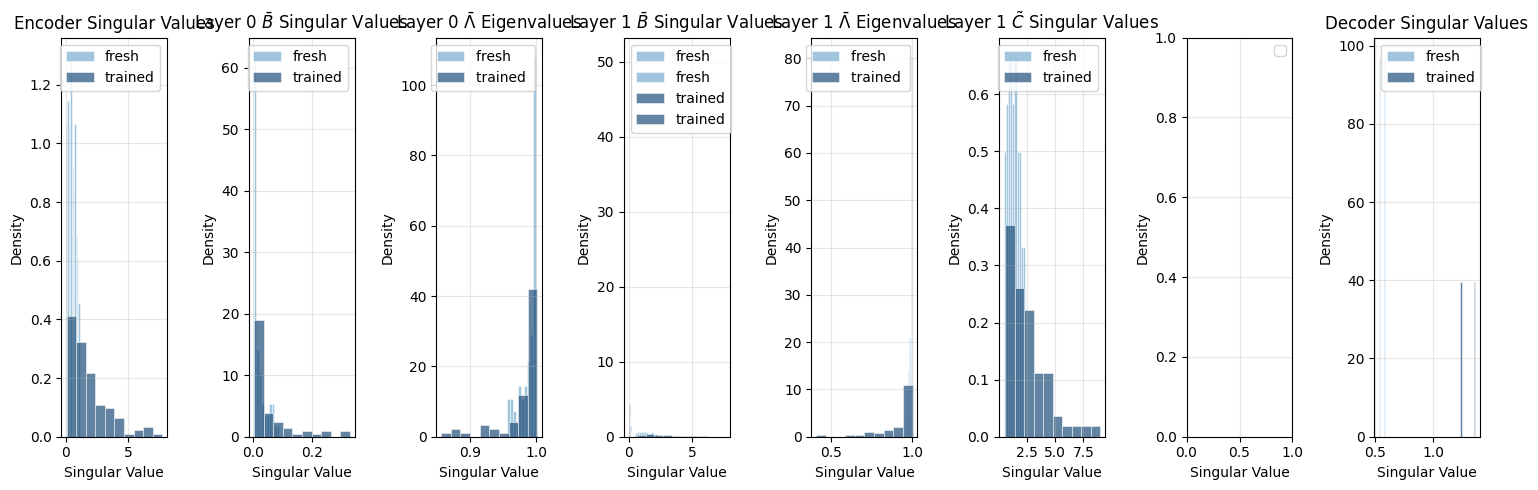

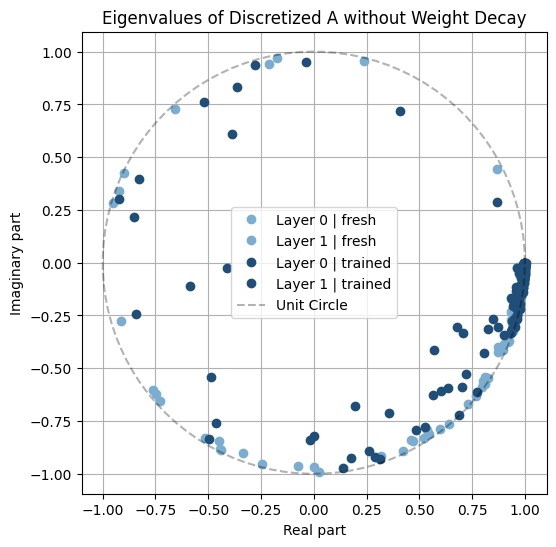

In [7]:
discretized_parameters = {'fresh': {}, 'trained': {}}
artifact_full_name = 'melinajingting-ucl/foundational_ssm_downstream_decoding/fixinf_rtt_trial_scratch_l2_d128_checkpoint:best'
model, trained_model = load_model_from_checkpoint(artifact_full_name, model_class=SSMDownstreamDecoder)
models = {
    'fresh': model, 
    'trained': trained_model
}

fig, axs = plt.subplots(1, 2 + 3 * len(model.ssm_blocks), figsize=(15, 5))
axs = axs.flatten()

# Color scheme: light colors for "fresh" (before), dark colors for "trained" (after)
colors = {
    'fresh': "#7AADCF",    # Light blue (before)
    'trained': '#1F4E79'   # Dark blue (after)
}

for train_status, m in models.items():
    color = colors[train_status]
    
    # Plot singular values of encoder 
    encoder_sv = jnp.linalg.svd(m.encoder.weight, compute_uv=False)
    axs[0].hist(np.abs(encoder_sv), alpha=0.7, label=f'{train_status}', 
                density=True, color=color, edgecolor='white', linewidth=0.5)
    axs[0].set_title('Encoder Singular Values')

    for i, layer in enumerate(m.ssm_blocks):
        Lambda_bar, B_bar, C_tilde, Delta = get_discretized_ssm_parameters(layer.ssm)
        
        # Plot singular values of B 
        b_sv = jnp.linalg.svd(B_bar, compute_uv=False)
        axs[1 + i*2].hist(np.abs(b_sv), alpha=0.7, label=f'{train_status}', 
                          density=True, color=color, edgecolor='white', linewidth=0.5)
        axs[1 + i*2].set_title(f'Layer {i}' +r' $\bar{B}$' + ' Singular Values')

        # Plot singular values of Lambda_bar
        axs[2 + i*2].hist(np.abs(Lambda_bar), alpha=0.7, label=f'{train_status} ', 
                          density=True, color=color, edgecolor='white', linewidth=0.5)
        axs[2 + i*2].set_title(f'Layer {i}' +r' $\bar{\Lambda}$' + ' Eigenvalues')
    
        c_sv = jnp.linalg.svd(C_tilde, compute_uv=False)
        axs[3 + i*2].hist(np.abs(c_sv), alpha=0.7, label=f'{train_status}', 
                    density=True, color=color, edgecolor='white', linewidth=0.5)
        axs[3 + i*2].set_title(f'Layer {i}' +r' $\tilde{C}$' + ' Singular Values')

    decoder_sv = jnp.linalg.svd(m.decoder.weight, compute_uv=False)
    axs[-1].hist(np.abs(decoder_sv), alpha=0.7, label=f'{train_status}', 
                 density=True, color=color, edgecolor='white', linewidth=0.5)
    axs[-1].set_title('Decoder Singular Values')

for ax in axs:
    ax.set_xlabel('Singular Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)
fig.tight_layout()
fig.show()


fig = plt.figure(figsize=(6, 6))

for i, (train_status, m) in enumerate(models.items()):
    color = colors[train_status]
    for i, ssm_block in enumerate(m.ssm_blocks):
        Lambda_bar, B_bar, C_tilde, Delta = get_discretized_ssm_parameters(ssm_block.ssm)
        plt.plot(Lambda_bar.real, Lambda_bar.imag, 'o', label=f'Layer {i} | {train_status}', color=color)

# draw unit circle
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'k--', label='Unit Circle', alpha=0.3)
plt.title('Eigenvalues of Discretized A without Weight Decay')
plt.axis('equal')
plt.grid()
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.legend()

In [ ]:
Observing that the trajectories are still rough, I hypothesized that higher frequencies caused by large imaginary part of discretized A matrix was biasing the model to overfit to local oscillations. 

<class 'omegaconf.dictconfig.DictConfig'>


wandb:   1 of 1 files downloaded.  


Loading checkpoint from: /tmp/tmp2t7cabzc/tmpu57shq2c.ckpt


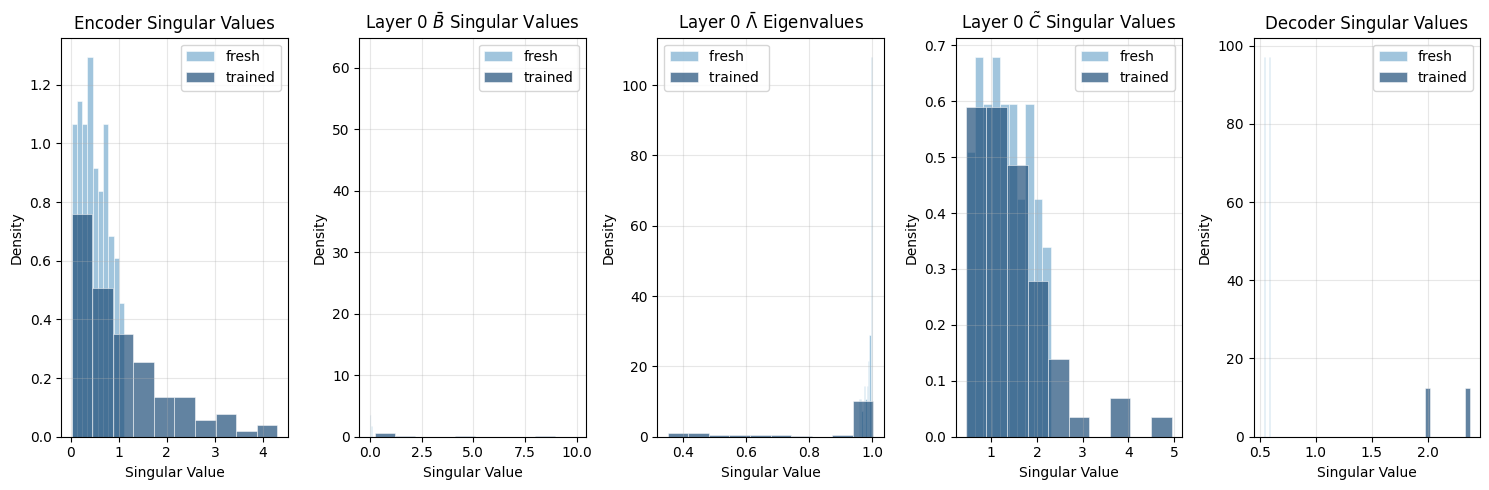

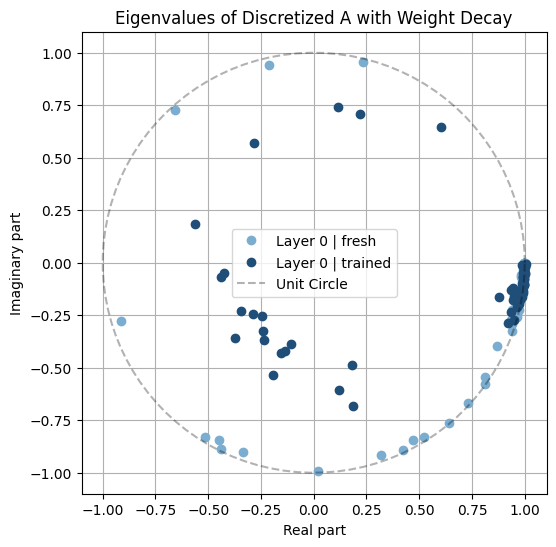

In [40]:
discretized_parameters = {'fresh': {}, 'trained': {}}
artifact_full_name = 'melinajingting-ucl/foundational_ssm_downstream_decoding/wd05_rtt_og_scratch_l1_d128_checkpoint:best'
model, trained_model = load_model_from_checkpoint(artifact_full_name, model_class=SSMDownstreamDecoder)
models = {
    'fresh': model, 
    'trained': trained_model
}

fig, axs = plt.subplots(1, 2 + 3 * len(model.ssm_blocks), figsize=(15, 5))
axs = axs.flatten()

# Color scheme: light colors for "fresh" (before), dark colors for "trained" (after)
colors = {
    'fresh': "#7AADCF",    # Light blue (before)
    'trained': '#1F4E79'   # Dark blue (after)
}

for train_status, m in models.items():
    color = colors[train_status]
    
    # Plot singular values of encoder 
    encoder_sv = jnp.linalg.svd(m.encoder.weight, compute_uv=False)
    axs[0].hist(np.abs(encoder_sv), alpha=0.7, label=f'{train_status}', 
                density=True, color=color, edgecolor='white', linewidth=0.5)
    axs[0].set_title('Encoder Singular Values')

    for i, layer in enumerate(m.ssm_blocks):
        Lambda_bar, B_bar, C_tilde, Delta = get_discretized_ssm_parameters(layer.ssm)
        
        # Plot singular values of B 
        b_sv = jnp.linalg.svd(B_bar, compute_uv=False)
        axs[1 + i*2].hist(np.abs(b_sv), alpha=0.7, label=f'{train_status}', 
                          density=True, color=color, edgecolor='white', linewidth=0.5)
        axs[1 + i*2].set_title(f'Layer {i}' +r' $\bar{B}$' + ' Singular Values')

        # Plot singular values of Lambda_bar
        axs[2 + i*2].hist(np.abs(Lambda_bar), alpha=0.7, label=f'{train_status} ', 
                          density=True, color=color, edgecolor='white', linewidth=0.5)
        axs[2 + i*2].set_title(f'Layer {i}' +r' $\bar{\Lambda}$' + ' Eigenvalues')
    
        c_sv = jnp.linalg.svd(C_tilde, compute_uv=False)
        axs[3 + i*2].hist(np.abs(c_sv), alpha=0.7, label=f'{train_status}', 
                    density=True, color=color, edgecolor='white', linewidth=0.5)
        axs[3 + i*2].set_title(f'Layer {i}' +r' $\tilde{C}$' + ' Singular Values')

    decoder_sv = jnp.linalg.svd(m.decoder.weight, compute_uv=False)
    axs[-1].hist(np.abs(decoder_sv), alpha=0.7, label=f'{train_status}', 
                 density=True, color=color, edgecolor='white', linewidth=0.5)
    axs[-1].set_title('Decoder Singular Values')

for ax in axs:
    ax.set_xlabel('Singular Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)
fig.tight_layout()
fig.show()


fig = plt.figure(figsize=(6, 6))

for i, (train_status, m) in enumerate(models.items()):
    color = colors[train_status]
    for i, ssm_block in enumerate(m.ssm_blocks):
        Lambda_bar, B_bar, C_tilde, Delta = get_discretized_ssm_parameters(ssm_block.ssm)
        plt.plot(Lambda_bar.real, Lambda_bar.imag, 'o', label=f'Layer {i} | {train_status}', color=color)

# draw unit circle
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'k--', label='Unit Circle', alpha=0.3)
plt.title('Eigenvalues of Discretized A with Weight Decay')
plt.axis('equal')
plt.grid()
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.legend()

<class 'omegaconf.dictconfig.DictConfig'>


wandb:   1 of 1 files downloaded.  


Loading checkpoint from: /tmp/tmpojf_dmfx/tmp4q6iv78y.ckpt


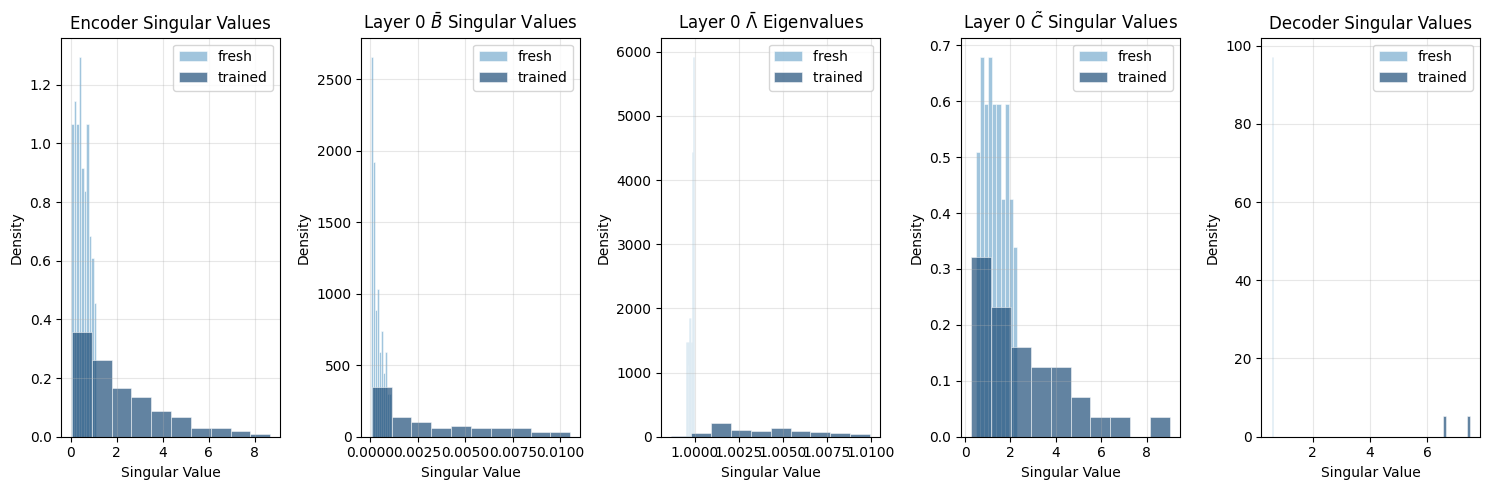

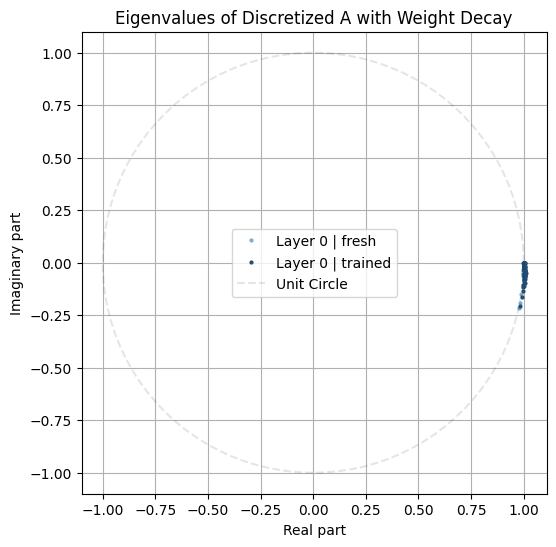

In [7]:
discretized_parameters = {'fresh': {}, 'trained': {}}
artifact_full_name = 'melinajingting-ucl/foundational_ssm_downstream_decoding/eddrop01_rtt_og_scratch_l1_d128_dt0001_checkpoint:best'
model, trained_model = load_model_from_checkpoint(artifact_full_name, model_class=SSMDownstreamDecoder)
models = {
    'fresh': model, 
    'trained': trained_model
}

fig, axs = plt.subplots(1, 2 + 3 * len(model.ssm_blocks), figsize=(15, 5))
axs = axs.flatten()

# Color scheme: light colors for "fresh" (before), dark colors for "trained" (after)
colors = {
    'fresh': "#7AADCF",    # Light blue (before)
    'trained': '#1F4E79'   # Dark blue (after)
}

for train_status, m in models.items():
    color = colors[train_status]
    
    # Plot singular values of encoder 
    encoder_sv = jnp.linalg.svd(m.encoder.weight, compute_uv=False)
    axs[0].hist(np.abs(encoder_sv), alpha=0.7, label=f'{train_status}', 
                density=True, color=color, edgecolor='white', linewidth=0.5)
    axs[0].set_title('Encoder Singular Values')

    for i, layer in enumerate(m.ssm_blocks):
        Lambda_bar, B_bar, C_tilde, Delta = get_discretized_ssm_parameters(layer.ssm)
        
        # Plot singular values of B 
        b_sv = jnp.linalg.svd(B_bar, compute_uv=False)
        axs[1 + i*2].hist(np.abs(b_sv), alpha=0.7, label=f'{train_status}', 
                          density=True, color=color, edgecolor='white', linewidth=0.5)
        axs[1 + i*2].set_title(f'Layer {i}' +r' $\bar{B}$' + ' Singular Values')

        # Plot singular values of Lambda_bar
        axs[2 + i*2].hist(np.abs(Lambda_bar), alpha=0.7, label=f'{train_status} ', 
                          density=True, color=color, edgecolor='white', linewidth=0.5)
        axs[2 + i*2].set_title(f'Layer {i}' +r' $\bar{\Lambda}$' + ' Eigenvalues')
    
        c_sv = jnp.linalg.svd(C_tilde, compute_uv=False)
        axs[3 + i*2].hist(np.abs(c_sv), alpha=0.7, label=f'{train_status}', 
                    density=True, color=color, edgecolor='white', linewidth=0.5)
        axs[3 + i*2].set_title(f'Layer {i}' +r' $\tilde{C}$' + ' Singular Values')

    decoder_sv = jnp.linalg.svd(m.decoder.weight, compute_uv=False)
    axs[-1].hist(np.abs(decoder_sv), alpha=0.7, label=f'{train_status}', 
                 density=True, color=color, edgecolor='white', linewidth=0.5)
    axs[-1].set_title('Decoder Singular Values')

for ax in axs:
    ax.set_xlabel('Singular Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)
fig.tight_layout()
fig.show()


fig = plt.figure(figsize=(6, 6))

for i, (train_status, m) in enumerate(models.items()):
    color = colors[train_status]
    for i, ssm_block in enumerate(m.ssm_blocks):
        Lambda_bar, B_bar, C_tilde, Delta = get_discretized_ssm_parameters(ssm_block.ssm)
        plt.plot(Lambda_bar.real, Lambda_bar.imag, 'o', label=f'Layer {i} | {train_status}', color=color, markersize=2)

# draw unit circle
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'k--', label='Unit Circle', alpha=0.1)
plt.title('Eigenvalues of Discretized A with Weight Decay')
plt.axis('equal')
plt.grid()
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.legend()

<class 'omegaconf.dictconfig.DictConfig'>


wandb:   1 of 1 files downloaded.  


Loading checkpoint from: /tmp/tmpt4cdkbcj/tmp35lawxb_.ckpt


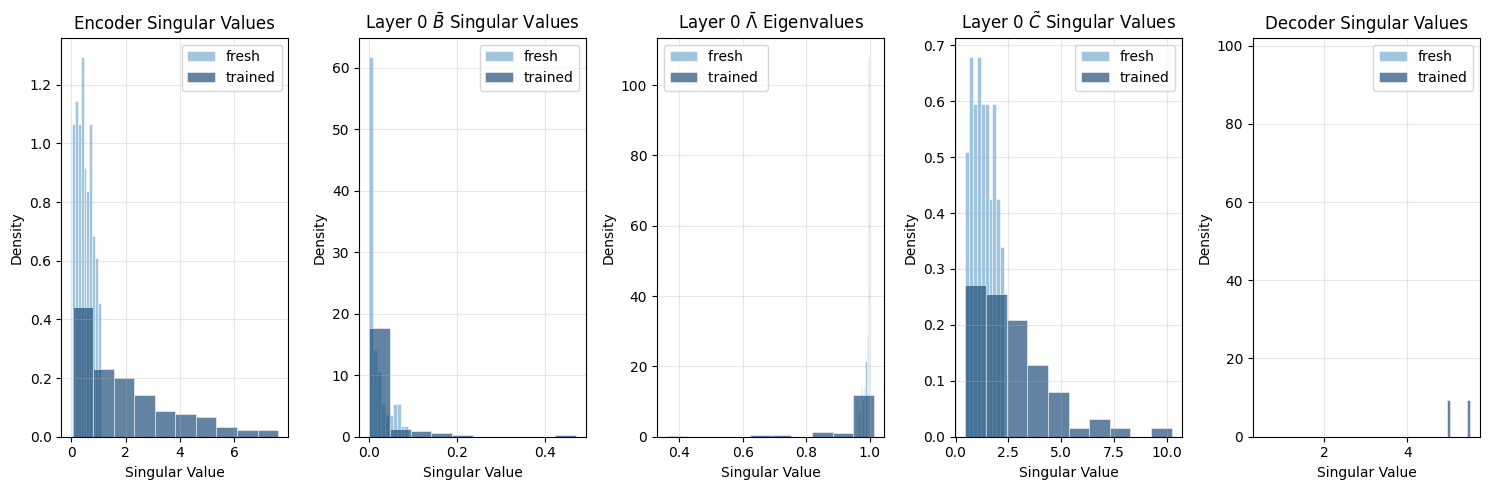

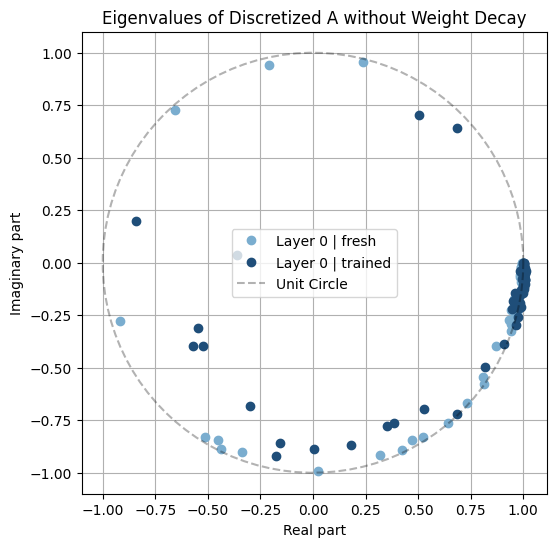

In [6]:
discretized_parameters = {'fresh': {}, 'trained': {}}
artifact_full_name = 'melinajingting-ucl/foundational_ssm_downstream_decoding/dt01_rtt_og_scratch_l1_d128_dt0001_checkpoint:best'
model, trained_model = load_model_from_checkpoint(artifact_full_name, model_class=SSMDownstreamDecoder)
models = {
    'fresh': model, 
    'trained': trained_model
}

fig, axs = plt.subplots(1, 2 + 3 * len(model.ssm_blocks), figsize=(15, 5))
axs = axs.flatten()

# Color scheme: light colors for "fresh" (before), dark colors for "trained" (after)
colors = {
    'fresh': "#7AADCF",    # Light blue (before)
    'trained': '#1F4E79'   # Dark blue (after)
}

for train_status, m in models.items():
    color = colors[train_status]
    
    # Plot singular values of encoder 
    encoder_sv = jnp.linalg.svd(m.encoder.weight, compute_uv=False)
    axs[0].hist(np.abs(encoder_sv), alpha=0.7, label=f'{train_status}', 
                density=True, color=color, edgecolor='white', linewidth=0.5)
    axs[0].set_title('Encoder Singular Values')

    for i, layer in enumerate(m.ssm_blocks):
        Lambda_bar, B_bar, C_tilde, Delta = get_discretized_ssm_parameters(layer.ssm)
        
        # Plot singular values of B 
        b_sv = jnp.linalg.svd(B_bar, compute_uv=False)
        axs[1 + i*2].hist(np.abs(b_sv), alpha=0.7, label=f'{train_status}', 
                          density=True, color=color, edgecolor='white', linewidth=0.5)
        axs[1 + i*2].set_title(f'Layer {i}' +r' $\bar{B}$' + ' Singular Values')

        # Plot singular values of Lambda_bar
        axs[2 + i*2].hist(np.abs(Lambda_bar), alpha=0.7, label=f'{train_status} ', 
                          density=True, color=color, edgecolor='white', linewidth=0.5)
        axs[2 + i*2].set_title(f'Layer {i}' +r' $\bar{\Lambda}$' + ' Eigenvalues')
    
        c_sv = jnp.linalg.svd(C_tilde, compute_uv=False)
        axs[3 + i*2].hist(np.abs(c_sv), alpha=0.7, label=f'{train_status}', 
                    density=True, color=color, edgecolor='white', linewidth=0.5)
        axs[3 + i*2].set_title(f'Layer {i}' +r' $\tilde{C}$' + ' Singular Values')

    decoder_sv = jnp.linalg.svd(m.decoder.weight, compute_uv=False)
    axs[-1].hist(np.abs(decoder_sv), alpha=0.7, label=f'{train_status}', 
                 density=True, color=color, edgecolor='white', linewidth=0.5)
    axs[-1].set_title('Decoder Singular Values')

for ax in axs:
    ax.set_xlabel('Singular Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)
fig.tight_layout()
fig.show()


fig = plt.figure(figsize=(6, 6))

for i, (train_status, m) in enumerate(models.items()):
    color = colors[train_status]
    for i, ssm_block in enumerate(m.ssm_blocks):
        Lambda_bar, B_bar, C_tilde, Delta = get_discretized_ssm_parameters(ssm_block.ssm)
        plt.plot(Lambda_bar.real, Lambda_bar.imag, 'o', label=f'Layer {i} | {train_status}', color=color)

# draw unit circle
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'k--', label='Unit Circle', alpha=0.3)
plt.title('Eigenvalues of Discretized A without Weight Decay')
plt.axis('equal')
plt.grid()
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.legend()

# Compare trajectories with eigenvalues

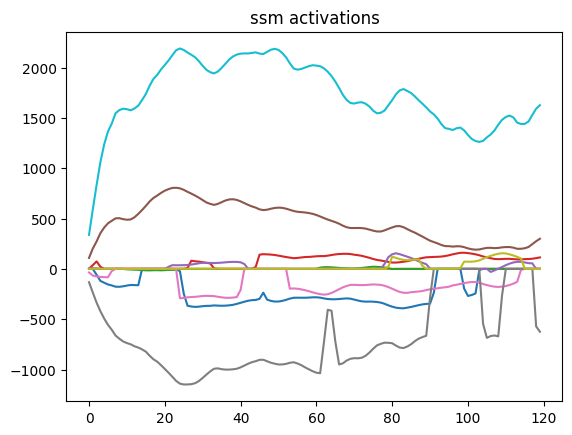

wandb: Downloading large artifact fixinf_rtt_trial_scratch_l1_d128_predictions_and_activations:latest, 196.17MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4 (440.4MB/s)
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4 (440.4MB/s)


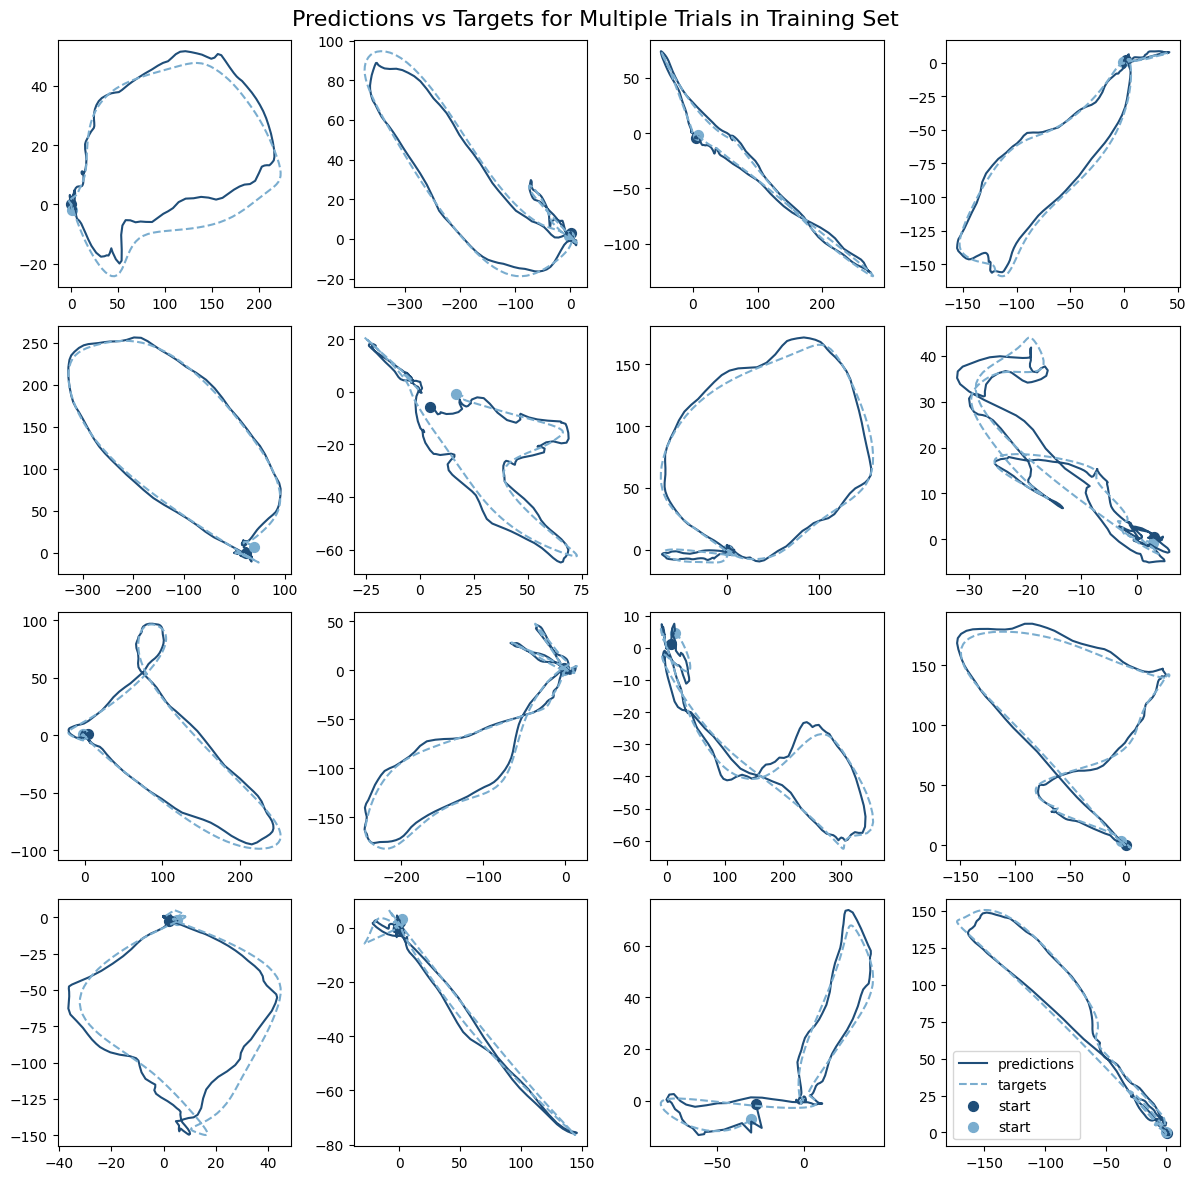

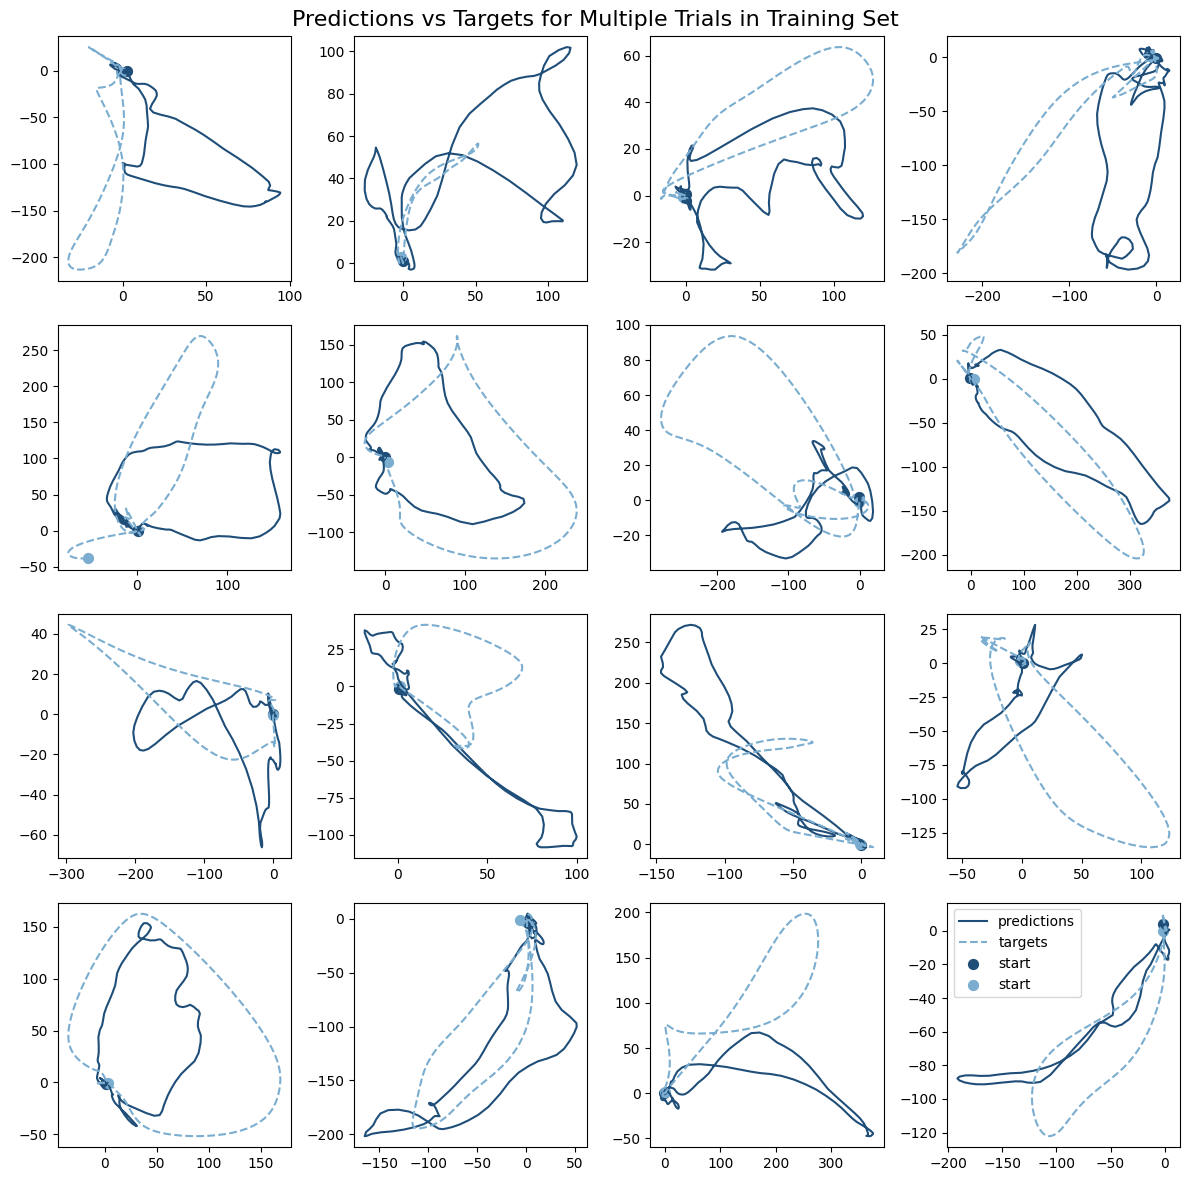

In [13]:
import matplotlib.pyplot as plt
from foundational_ssm.utils.wandb_utils_jax import load_h5_artifact_with_tempdir
artifact_full_name = 'melinajingting-ucl/foundational_ssm_downstream_decoding/fixinf_rtt_trial_scratch_l1_d128_predictions_and_activations:latest'

spksmth_artifact = load_h5_artifact_with_tempdir(artifact_full_name)
session_data = spksmth_artifact['sessions']['rtt_trial']

colors = {
    'target': "#7AADCF",    # Light blue (before)
    'prediction': '#1F4E79'   # Dark blue (after)
}
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
axs = axs.flatten()
starting_trial_id = 0
for i in range(16):
    trial_id = starting_trial_id + i
    # plot trajectories of predictions and targets, add a dot at start and arrow at end. 
    axs[i].plot(session_data['predictions'][trial_id,:,0], session_data['predictions'][trial_id,:,1], label='predictions', color=colors['prediction'])
    axs[i].plot(session_data['targets'][trial_id,:,0], session_data['targets'][trial_id,:,1], label='targets', color=colors['target'], linestyle='--')
    axs[i].scatter(session_data['predictions'][trial_id,0,0], session_data['predictions'][trial_id,0,1], color=colors['prediction'], s=50, label='start')
    axs[i].scatter(session_data['targets'][trial_id,0,0], session_data['targets'][trial_id,0,1], color=colors['target'], s=50, label='start')
    
fig.suptitle('Predictions vs Targets for Multiple Trials in Training Set', fontsize=16)
plt.legend()
plt.tight_layout()

fig, axs = plt.subplots(4, 4, figsize=(12, 12))
axs = axs.flatten()
starting_trial_id = 379
for i in range(16):
    trial_id = starting_trial_id + i
    # plot trajectories of predictions and targets, add a dot at start and arrow at end. 
    axs[i].plot(session_data['predictions'][trial_id,:,0], session_data['predictions'][trial_id,:,1], label='predictions', color=colors['prediction'])
    axs[i].plot(session_data['targets'][trial_id,:,0], session_data['targets'][trial_id,:,1], label='targets', color=colors['target'], linestyle='--')
    axs[i].scatter(session_data['predictions'][trial_id,0,0], session_data['predictions'][trial_id,0,1], color=colors['prediction'], s=50, label='start')
    axs[i].scatter(session_data['targets'][trial_id,0,0], session_data['targets'][trial_id,0,1], color=colors['target'], s=50, label='start')
    
fig.suptitle('Predictions vs Targets for Multiple Trials in Training Set', fontsize=16)
plt.legend()
plt.tight_layout()


wandb: Downloading large artifact dt01_rtt_trial_scratch_l1_d128_dt0001_predictions_and_activations:latest, 196.17MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (422.7MB/s)


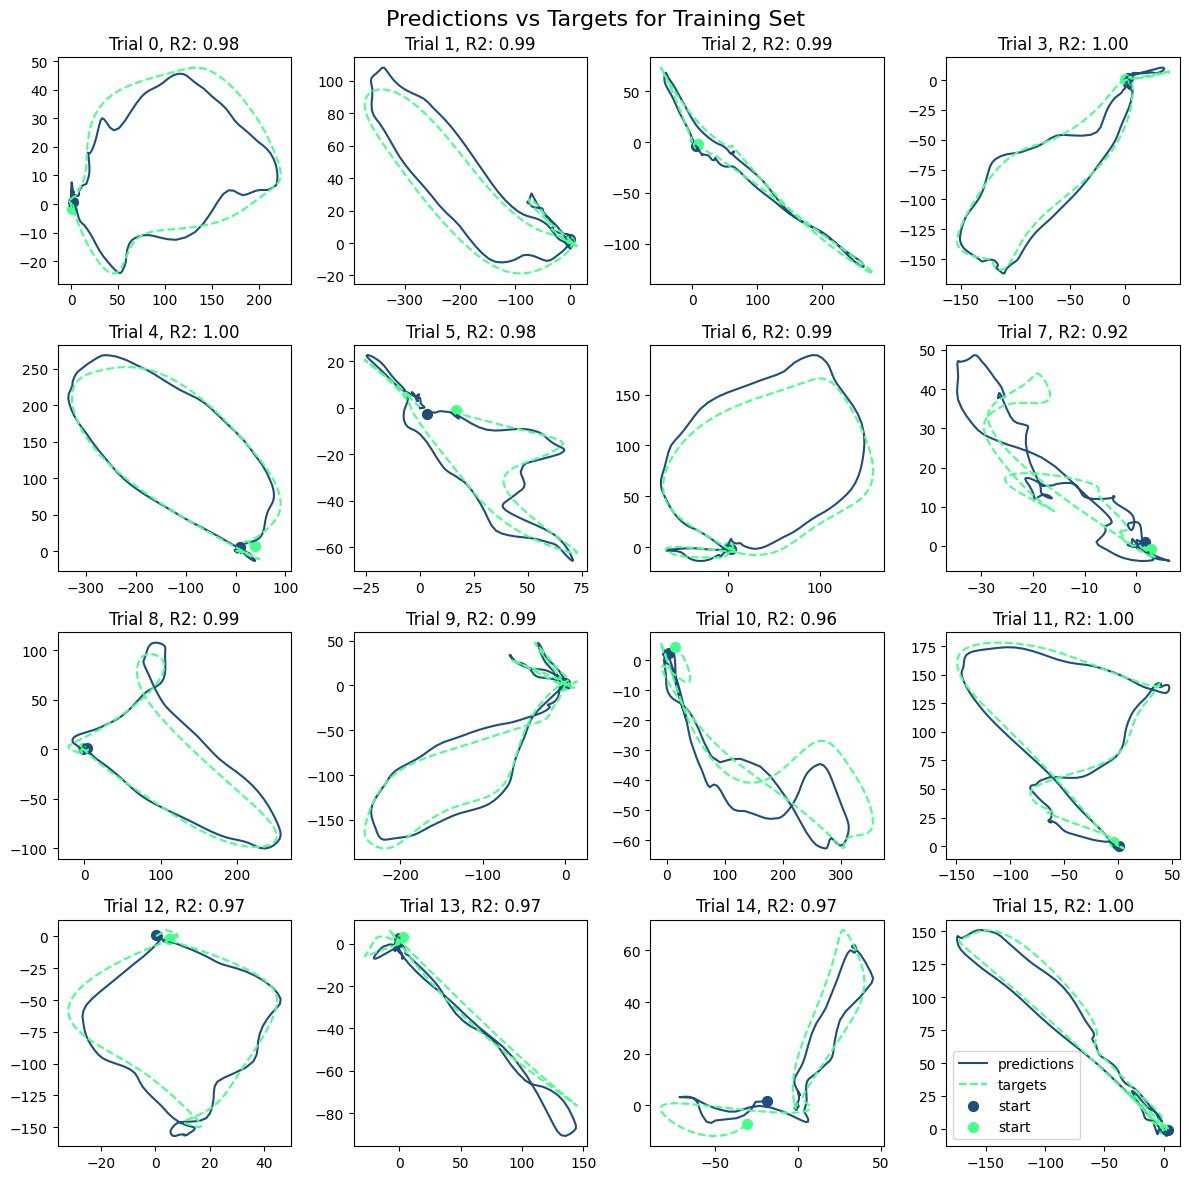

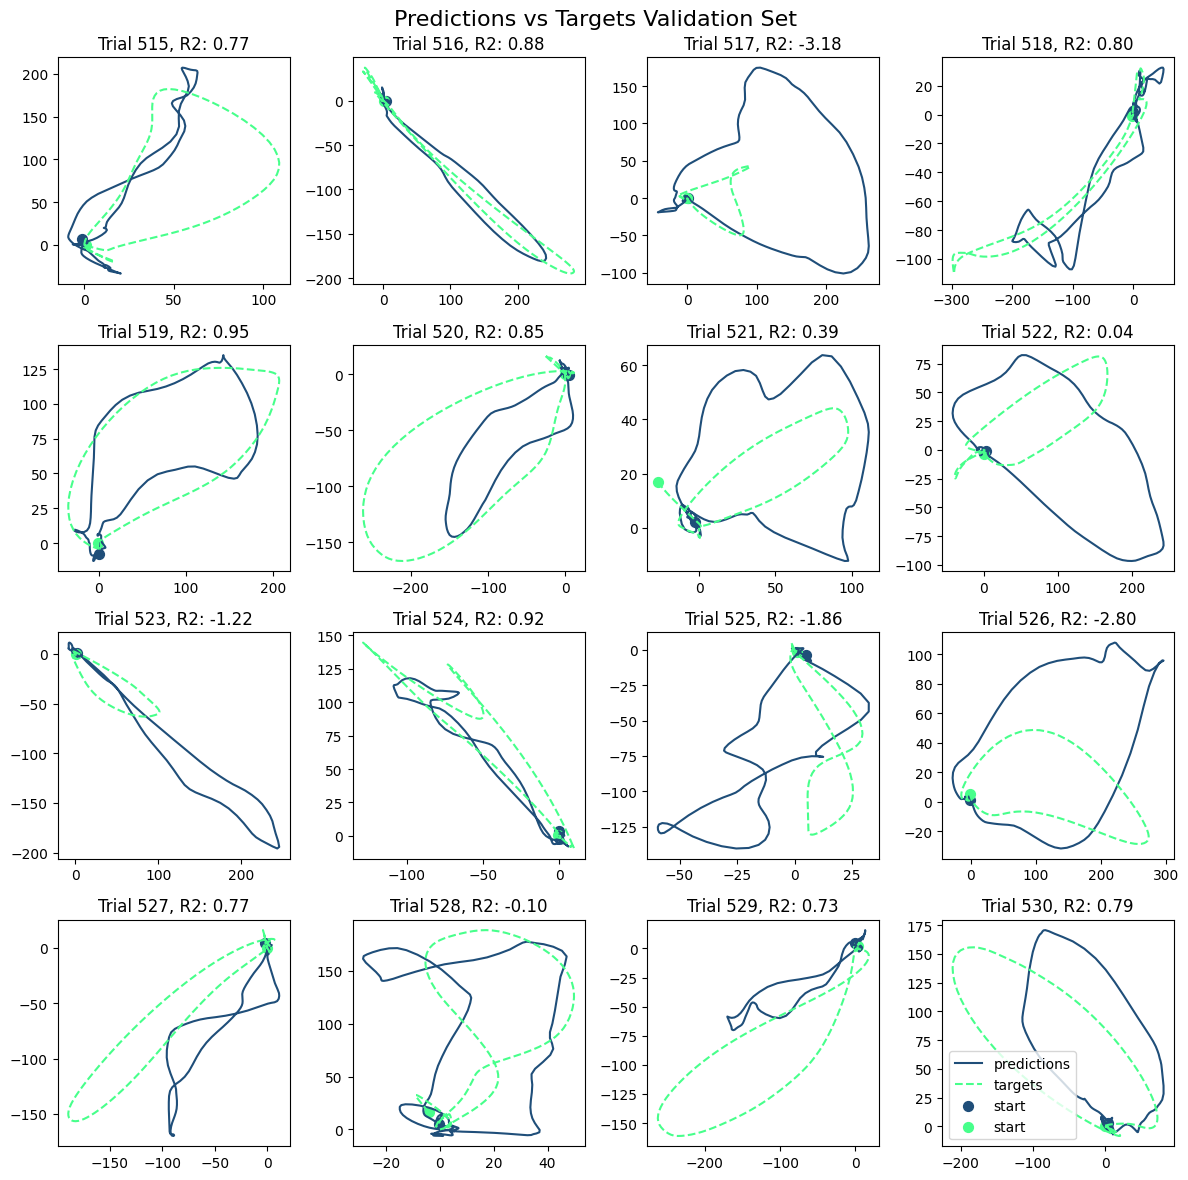

In [14]:
import matplotlib.pyplot as plt
from foundational_ssm.utils.wandb_utils_jax import load_h5_artifact_with_tempdir
artifact_full_name = 'melinajingting-ucl/foundational_ssm_downstream_decoding/dt01_rtt_trial_scratch_l1_d128_dt0001_predictions_and_activations:latest'

spksmth_artifact = load_h5_artifact_with_tempdir(artifact_full_name)
session_data = spksmth_artifact['sessions']['rtt_trial']

colors = {
    'target': "#47FF8B",    # Light blue (before)
    'prediction': '#1F4E79'   # Dark blue (after)
}
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
axs = axs.flatten()
starting_trial_id = 0
for i in range(16):
    trial_id = starting_trial_id + i
    # plot trajectories of predictions and targets, add a dot at start and arrow at end. 
    axs[i].plot(session_data['predictions'][trial_id,:,0], session_data['predictions'][trial_id,:,1], label='predictions', color=colors['prediction'])
    axs[i].plot(session_data['targets'][trial_id,:,0], session_data['targets'][trial_id,:,1], label='targets', color=colors['target'], linestyle='--')
    axs[i].scatter(session_data['predictions'][trial_id,0,0], session_data['predictions'][trial_id,0,1], color=colors['prediction'], s=50, label='start')
    axs[i].scatter(session_data['targets'][trial_id,0,0], session_data['targets'][trial_id,0,1], color=colors['target'], s=50, label='start')
    axs[i].set_title(f'Trial {trial_id}, R2: {r2_score(session_data["targets"][trial_id], session_data["predictions"][trial_id]):.2f}')
fig.suptitle('Predictions vs Targets for Training Set', fontsize=16)
plt.legend()
plt.tight_layout()

fig, axs = plt.subplots(4, 4, figsize=(12, 12))
axs = axs.flatten()
starting_trial_id = 515
for i in range(16):
    trial_id = starting_trial_id + i
    # plot trajectories of predictions and targets, add a dot at start and arrow at end. 
    axs[i].plot(session_data['predictions'][trial_id,:,0], session_data['predictions'][trial_id,:,1], label='predictions', color=colors['prediction'])
    axs[i].plot(session_data['targets'][trial_id,:,0], session_data['targets'][trial_id,:,1], label='targets', color=colors['target'], linestyle='--')
    axs[i].scatter(session_data['predictions'][trial_id,0,0], session_data['predictions'][trial_id,0,1], color=colors['prediction'], s=50, label='start')
    axs[i].scatter(session_data['targets'][trial_id,0,0], session_data['targets'][trial_id,0,1], color=colors['target'], s=50, label='start')
    axs[i].set_title(f'Trial {trial_id}, R2: {r2_score(session_data["targets"][trial_id], session_data["predictions"][trial_id]):.2f}')
fig.suptitle('Predictions vs Targets Validation Set', fontsize=16)
plt.legend()
plt.tight_layout()


wandb: Downloading large artifact dt01_rtt_og_scratch_l1_d128_dt0001_predictions_and_activations:v2, 67.25MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4 (160.0MB/s)


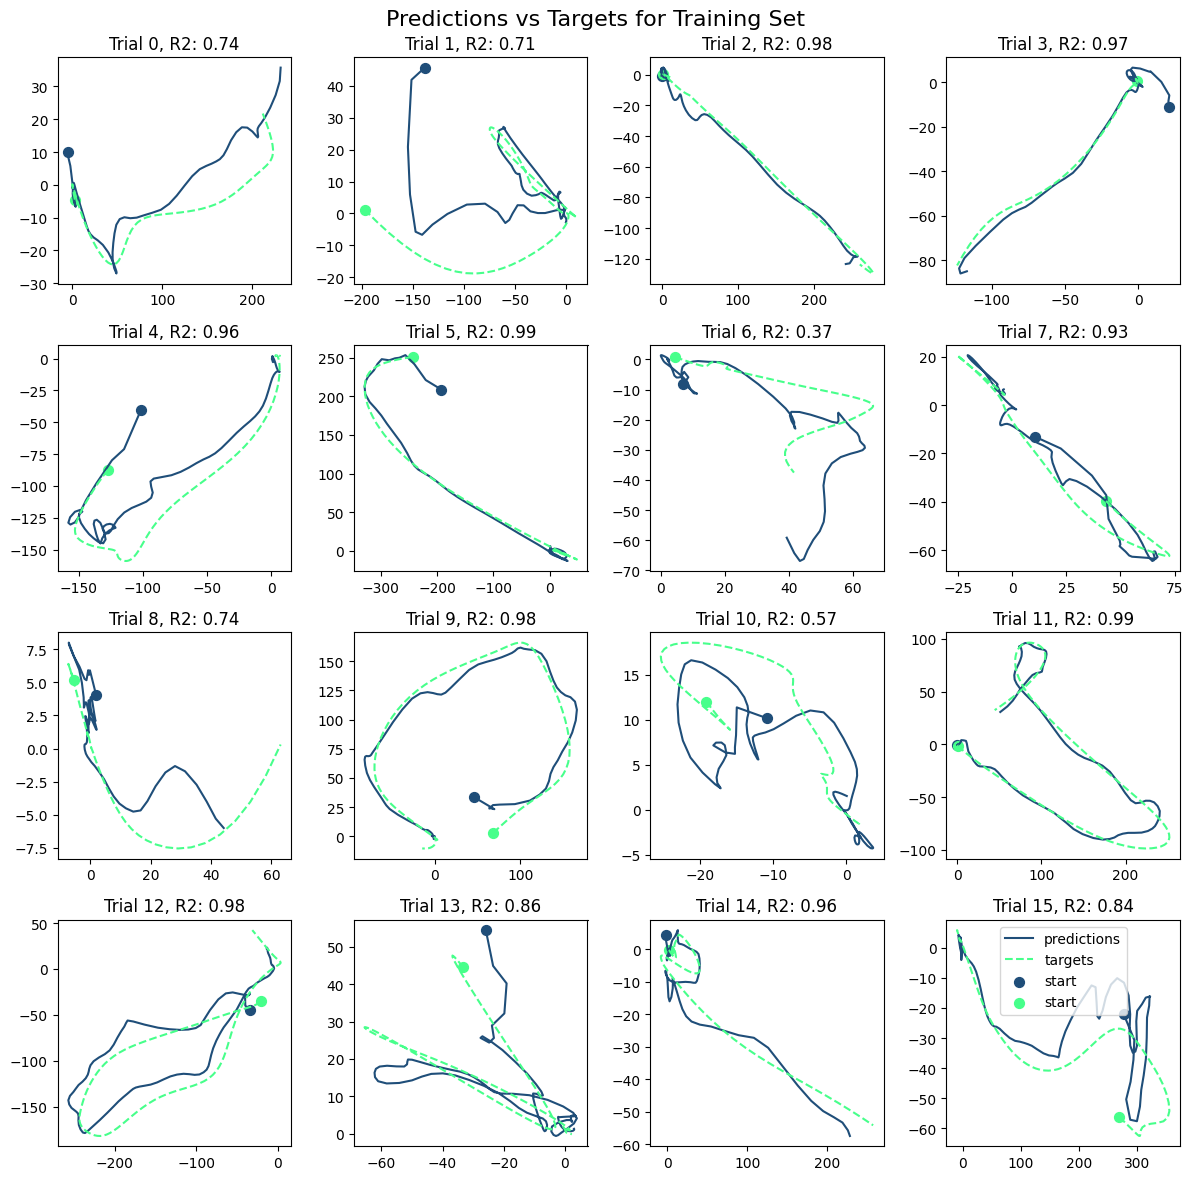

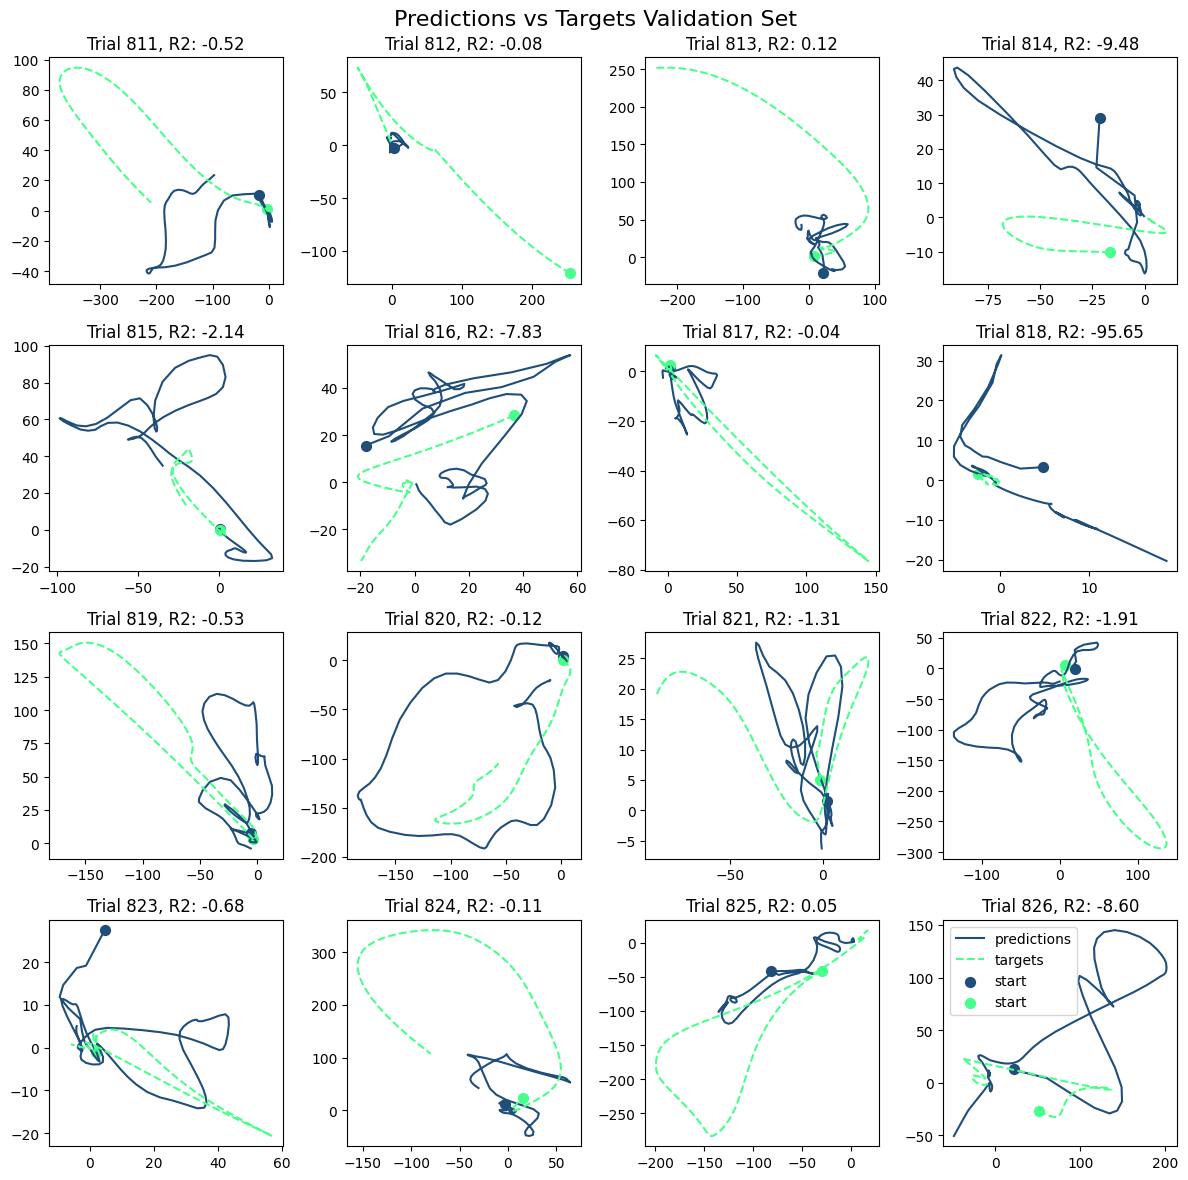

In [10]:
import matplotlib.pyplot as plt
from foundational_ssm.utils.wandb_utils_jax import load_h5_artifact_with_tempdir
from sklearn.metrics import r2_score
artifact_full_name = 'melinajingting-ucl/foundational_ssm_downstream_decoding/dt01_rtt_og_scratch_l1_d128_dt0001_predictions_and_activations:v2'

spksmth_artifact = load_h5_artifact_with_tempdir(artifact_full_name)
session_data = spksmth_artifact['sessions']['rtt_og']

colors = {
    'target': "#47FF8B",    # Light blue (before)
    'prediction': '#1F4E79'   # Dark blue (after)
}
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
axs = axs.flatten()
starting_trial_id = 0
for i in range(16):
    trial_id = starting_trial_id + i
    # plot trajectories of predictions and targets, add a dot at start and arrow at end. 
    axs[i].plot(session_data['predictions'][trial_id,:,0], session_data['predictions'][trial_id,:,1], label='predictions', color=colors['prediction'])
    axs[i].plot(session_data['targets'][trial_id,:,0], session_data['targets'][trial_id,:,1], label='targets', color=colors['target'], linestyle='--')
    axs[i].scatter(session_data['predictions'][trial_id,0,0], session_data['predictions'][trial_id,0,1], color=colors['prediction'], s=50, label='start')
    axs[i].scatter(session_data['targets'][trial_id,0,0], session_data['targets'][trial_id,0,1], color=colors['target'], s=50, label='start')
    axs[i].set_title(f'Trial {trial_id}, R2: {r2_score(session_data["targets"][trial_id], session_data["predictions"][trial_id]):.2f}')
fig.suptitle('Predictions vs Targets for Training Set', fontsize=16)
plt.legend()
plt.tight_layout()

fig, axs = plt.subplots(4, 4, figsize=(12, 12))
axs = axs.flatten()
starting_trial_id = 811
for i in range(16):
    trial_id = starting_trial_id + i
    # plot trajectories of predictions and targets, add a dot at start and arrow at end. 
    axs[i].plot(session_data['predictions'][trial_id,:,0], session_data['predictions'][trial_id,:,1], label='predictions', color=colors['prediction'])
    axs[i].plot(session_data['targets'][trial_id,:,0], session_data['targets'][trial_id,:,1], label='targets', color=colors['target'], linestyle='--')
    axs[i].scatter(session_data['predictions'][trial_id,0,0], session_data['predictions'][trial_id,0,1], color=colors['prediction'], s=50, label='start')
    axs[i].scatter(session_data['targets'][trial_id,0,0], session_data['targets'][trial_id,0,1], color=colors['target'], s=50, label='start')
    axs[i].set_title(f'Trial {trial_id}, R2: {r2_score(session_data["targets"][trial_id], session_data["predictions"][trial_id]):.2f}')
fig.suptitle('Predictions vs Targets Validation Set', fontsize=16)
plt.legend()
plt.tight_layout()


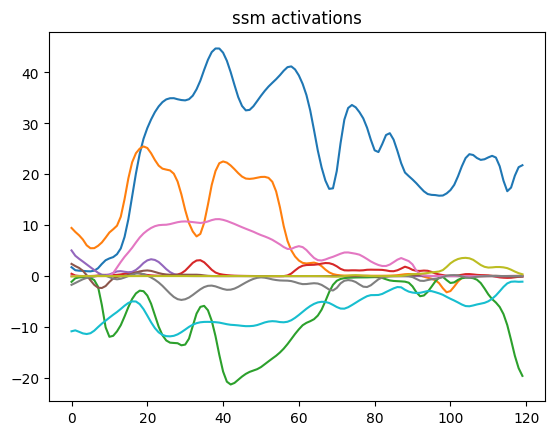

In [27]:
trial_id = 0
for i in range(10):
    plt.plot(session_data['activations']['ssm_block_0'][trial_id,:,i], label=f'unit {i}')
plt.title('ssm activations')
plt.show()